<a href="https://colab.research.google.com/github/SeungbeomDo/Time_Series_Analysis/blob/main/DeepAR_Stock_Returns_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터 및 라이브러리 임포트

In [ ]:
!pip install "gluonts[torch,pro]"
!pip install "gluonts[mxnet,pro]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 39.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 9.0.0
    Uninstalling pyarrow-9.0.0:
      Successfully uninstalled pyarrow-9.0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Financial Engineering/DeepAR/KOSPI200_951002_221028.csv', encoding = 'cp949')

In [ ]:
df_pr = df.iloc[:, 0:2]
df_pr.columns = ['Date', 'Price']
df_pr['Return'] = np.log(df_pr['Price']/df_pr['Price'].shift(1))
df_pr = df_pr.dropna()
df_pr['Date'] = pd.to_datetime(df_pr['Date'])
df_pr = df_pr.sort_values('Date')
df_pr = df_pr.set_index('Date')
df_pr

,Price,Return
Date,,
1995-10-02,111.15,-0.008332
1995-10-04,112.08,-0.006581
1995-10-05,112.82,-0.013208
1995-10-06,114.32,-0.002882
1995-10-07,114.65,-0.004699
...,...,...
2022-10-21,288.57,-0.009999
2022-10-24,291.47,-0.000377
2022-10-25,291.58,-0.007755


#Window Rolling

In [ ]:
context_length = 10 #현 시점까지 주어진 context_length 길이의 인풋시퀀스를 가지고
prediction_length = 1 #이후 prediction_length 길이의 아웃풋 시퀀스를 예측

window_size = context_length + prediction_length #context와 prediction을 포함하는 하나의 window
step_size = 1 #window를 1시점씩 밀면서 훈련하고 예측하기 반복
              #매 winodow에서 context_length로 prediction_length 예측하기 훈련


In [ ]:
df_pr = df_pr.iloc[-101:]
df_pr

,Price,Return
Date,,
2022-05-31,354.54,0.011432
2022-06-02,350.51,-0.004270
2022-06-03,352.01,0.018175
2022-06-07,345.67,-0.001590
2022-06-08,346.22,-0.001155
...,...,...
2022-10-21,288.57,-0.009999
2022-10-24,291.47,-0.000377
2022-10-25,291.58,-0.007755


In [ ]:
def create_dataset(df):
    target_values = df['Return'].values
    data = {"start": df.index[0], "target": target_values}
    return ListDataset([data], freq="1D")

#모델 구현

In [ ]:
from gluonts.mx.distribution import StudentTOutput, GaussianOutput, LaplaceOutput, GenParetoOutput

In [ ]:
callbacks = [
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=10))
]

estimator = DeepAREstimator(
    freq="1D", #
    prediction_length=1,
    context_length=10,
    num_cells=20,
    num_layers=1,
    dropout_rate=0.1,
    distr_output=GaussianOutput(),
    trainer=Trainer(epochs=10,
                    callbacks=callbacks)
)

#모델 훈련

In [ ]:
models = []
for i in range(0, int((len(df_pr) - window_size)/step_size + 1), step_size):
    print(f"train window {i+1} of total {int((len(df_pr) - window_size)/step_size + 1)} windows")
    window_df_train = df_pr.iloc[i:i+window_size]
    window_data_train = create_dataset(window_df_train)
    print(window_data_train)

    estimator = DeepAREstimator(
    freq="1D", #
    prediction_length=1,
    context_length=10,
    num_cells=20,
    num_layers=1,
    dropout_rate=0.1,
    distr_output=GaussianOutput(),
    trainer=Trainer(epochs=10,
                    callbacks=callbacks)
)
    
    model = estimator.train(window_data_train)
    models.append(model)

train window 1 of total 91 windows
[{'start': Period('2022-05-31', 'D'), 'target': array([ 0.01143194, -0.00427035,  0.01817502, -0.00158985, -0.00115467,
        0.01374003,  0.0357601 ,  0.00501437,  0.01851108, -0.00012413,
        0.00672544], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 24.29it/s, epoch=10/10, avg_epoch_loss=-5.55]


train window 2 of total 91 windows
[{'start': Period('2022-06-02', 'D'), 'target': array([-0.00427035,  0.01817502, -0.00158985, -0.00115467,  0.01374003,
        0.0357601 ,  0.00501437,  0.01851108, -0.00012413,  0.00672544,
        0.01780893], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 24.47it/s, epoch=10/10, avg_epoch_loss=-4.62]


train window 3 of total 91 windows
[{'start': Period('2022-06-03', 'D'), 'target': array([ 0.01817502, -0.00158985, -0.00115467,  0.01374003,  0.0357601 ,
        0.00501437,  0.01851108, -0.00012413,  0.00672544,  0.01780893,
       -0.00615074], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.53it/s, epoch=10/10, avg_epoch_loss=-4.48]


train window 4 of total 91 windows
[{'start': Period('2022-06-07', 'D'), 'target': array([-0.00158985, -0.00115467,  0.01374003,  0.0357601 ,  0.00501437,
        0.01851108, -0.00012413,  0.00672544,  0.01780893, -0.00615074,
        0.02658453], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.11it/s, epoch=10/10, avg_epoch_loss=-2.95]


train window 5 of total 91 windows
[{'start': Period('2022-06-08', 'D'), 'target': array([-0.00115467,  0.01374003,  0.0357601 ,  0.00501437,  0.01851108,
       -0.00012413,  0.00672544,  0.01780893, -0.00615074,  0.02658453,
        0.00857339], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 24.27it/s, epoch=10/10, avg_epoch_loss=-2.5]


train window 6 of total 91 windows
[{'start': Period('2022-06-09', 'D'), 'target': array([ 0.01374003,  0.0357601 ,  0.00501437,  0.01851108, -0.00012413,
        0.00672544,  0.01780893, -0.00615074,  0.02658453,  0.00857339,
       -0.02144142], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 27.50it/s, epoch=10/10, avg_epoch_loss=-3.1]


train window 7 of total 91 windows
[{'start': Period('2022-06-10', 'D'), 'target': array([ 0.0357601 ,  0.00501437,  0.01851108, -0.00012413,  0.00672544,
        0.01780893, -0.00615074,  0.02658453,  0.00857339, -0.02144142,
       -0.0131474 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 26.85it/s, epoch=10/10, avg_epoch_loss=-2.76]


train window 8 of total 91 windows
[{'start': Period('2022-06-13', 'D'), 'target': array([ 0.00501437,  0.01851108, -0.00012413,  0.00672544,  0.01780893,
       -0.00615074,  0.02658453,  0.00857339, -0.02144142, -0.0131474 ,
       -0.00916095], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.33it/s, epoch=10/10, avg_epoch_loss=-3.21]


train window 9 of total 91 windows
[{'start': Period('2022-06-14', 'D'), 'target': array([ 0.01851108, -0.00012413,  0.00672544,  0.01780893, -0.00615074,
        0.02658453,  0.00857339, -0.02144142, -0.0131474 , -0.00916095,
        0.01978006], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.66it/s, epoch=10/10, avg_epoch_loss=-3.09]


train window 10 of total 91 windows
[{'start': Period('2022-06-15', 'D'), 'target': array([-0.00012413,  0.00672544,  0.01780893, -0.00615074,  0.02658453,
        0.00857339, -0.02144142, -0.0131474 , -0.00916095,  0.01978006,
        0.0182568 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.04it/s, epoch=10/10, avg_epoch_loss=21.8]


train window 11 of total 91 windows
[{'start': Period('2022-06-16', 'D'), 'target': array([ 0.00672544,  0.01780893, -0.00615074,  0.02658453,  0.00857339,
       -0.02144142, -0.0131474 , -0.00916095,  0.01978006,  0.0182568 ,
        0.01040551], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.46it/s, epoch=10/10, avg_epoch_loss=-3.11]


train window 12 of total 91 windows
[{'start': Period('2022-06-17', 'D'), 'target': array([ 1.78089272e-02, -6.15074392e-03,  2.65845340e-02,  8.57339054e-03,
       -2.14414224e-02, -1.31474035e-02, -9.16094612e-03,  1.97800640e-02,
        1.82568040e-02,  1.04055125e-02,  3.28931128e-05], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.62it/s, epoch=10/10, avg_epoch_loss=-2.86]


train window 13 of total 91 windows
[{'start': Period('2022-06-20', 'D'), 'target': array([-6.15074392e-03,  2.65845340e-02,  8.57339054e-03, -2.14414224e-02,
       -1.31474035e-02, -9.16094612e-03,  1.97800640e-02,  1.82568040e-02,
        1.04055125e-02,  3.28931128e-05, -1.63777638e-02], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.45it/s, epoch=10/10, avg_epoch_loss=-2.61]


train window 14 of total 91 windows
[{'start': Period('2022-06-21', 'D'), 'target': array([ 2.65845340e-02,  8.57339054e-03, -2.14414224e-02, -1.31474035e-02,
       -9.16094612e-03,  1.97800640e-02,  1.82568040e-02,  1.04055125e-02,
        3.28931128e-05, -1.63777638e-02,  2.20846198e-02], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.76it/s, epoch=10/10, avg_epoch_loss=-2.77]


train window 15 of total 91 windows
[{'start': Period('2022-06-22', 'D'), 'target': array([ 8.57339054e-03, -2.14414224e-02, -1.31474035e-02, -9.16094612e-03,
        1.97800640e-02,  1.82568040e-02,  1.04055125e-02,  3.28931128e-05,
       -1.63777638e-02,  2.20846198e-02, -1.97520293e-02], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.17it/s, epoch=10/10, avg_epoch_loss=-2.85]


train window 16 of total 91 windows
[{'start': Period('2022-06-23', 'D'), 'target': array([-2.14414224e-02, -1.31474035e-02, -9.16094612e-03,  1.97800640e-02,
        1.82568040e-02,  1.04055125e-02,  3.28931128e-05, -1.63777638e-02,
        2.20846198e-02, -1.97520293e-02, -5.95028093e-03], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 32.87it/s, epoch=10/10, avg_epoch_loss=-2.89]


train window 17 of total 91 windows
[{'start': Period('2022-06-24', 'D'), 'target': array([-1.31474035e-02, -9.16094612e-03,  1.97800640e-02,  1.82568040e-02,
        1.04055125e-02,  3.28931128e-05, -1.63777638e-02,  2.20846198e-02,
       -1.97520293e-02, -5.95028093e-03,  6.01515314e-03], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 36.62it/s, epoch=10/10, avg_epoch_loss=-2.93]


train window 18 of total 91 windows
[{'start': Period('2022-06-27', 'D'), 'target': array([-9.16094612e-03,  1.97800640e-02,  1.82568040e-02,  1.04055125e-02,
        3.28931128e-05, -1.63777638e-02,  2.20846198e-02, -1.97520293e-02,
       -5.95028093e-03,  6.01515314e-03,  1.06307659e-02], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.96it/s, epoch=10/10, avg_epoch_loss=-2.99]


train window 19 of total 91 windows
[{'start': Period('2022-06-28', 'D'), 'target': array([ 1.97800640e-02,  1.82568040e-02,  1.04055125e-02,  3.28931128e-05,
       -1.63777638e-02,  2.20846198e-02, -1.97520293e-02, -5.95028093e-03,
        6.01515314e-03,  1.06307659e-02, -5.10121789e-03], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 25.88it/s, epoch=10/10, avg_epoch_loss=-3.16]


train window 20 of total 91 windows
[{'start': Period('2022-06-29', 'D'), 'target': array([ 1.82568040e-02,  1.04055125e-02,  3.28931128e-05, -1.63777638e-02,
        2.20846198e-02, -1.97520293e-02, -5.95028093e-03,  6.01515314e-03,
        1.06307659e-02, -5.10121789e-03,  4.05269023e-03], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 24.16it/s, epoch=10/10, avg_epoch_loss=-2.97]


train window 21 of total 91 windows
[{'start': Period('2022-06-30', 'D'), 'target': array([ 1.04055125e-02,  3.28931128e-05, -1.63777638e-02,  2.20846198e-02,
       -1.97520293e-02, -5.95028093e-03,  6.01515314e-03,  1.06307659e-02,
       -5.10121789e-03,  4.05269023e-03, -8.34887289e-03], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.30it/s, epoch=10/10, avg_epoch_loss=-2.95]


train window 22 of total 91 windows
[{'start': Period('2022-07-01', 'D'), 'target': array([ 3.2893113e-05, -1.6377764e-02,  2.2084620e-02, -1.9752029e-02,
       -5.9502809e-03,  6.0151531e-03,  1.0630766e-02, -5.1012179e-03,
        4.0526902e-03, -8.3488729e-03, -2.2352323e-02], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.83it/s, epoch=10/10, avg_epoch_loss=2.15e+3]


train window 23 of total 91 windows
[{'start': Period('2022-07-04', 'D'), 'target': array([-0.01637776,  0.02208462, -0.01975203, -0.00595028,  0.00601515,
        0.01063077, -0.00510122,  0.00405269, -0.00834887, -0.02235232,
        0.00308539], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.60it/s, epoch=10/10, avg_epoch_loss=-2.89]


train window 24 of total 91 windows
[{'start': Period('2022-07-05', 'D'), 'target': array([ 0.02208462, -0.01975203, -0.00595028,  0.00601515,  0.01063077,
       -0.00510122,  0.00405269, -0.00834887, -0.02235232,  0.00308539,
       -0.00673104], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.19it/s, epoch=10/10, avg_epoch_loss=-2.82]


train window 25 of total 91 windows
[{'start': Period('2022-07-06', 'D'), 'target': array([-0.01975203, -0.00595028,  0.00601515,  0.01063077, -0.00510122,
        0.00405269, -0.00834887, -0.02235232,  0.00308539, -0.00673104,
       -0.01151499], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 31.90it/s, epoch=10/10, avg_epoch_loss=-3.11]


train window 26 of total 91 windows
[{'start': Period('2022-07-07', 'D'), 'target': array([-0.00595028,  0.00601515,  0.01063077, -0.00510122,  0.00405269,
       -0.00834887, -0.02235232,  0.00308539, -0.00673104, -0.01151499,
        0.00737825], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 31.73it/s, epoch=10/10, avg_epoch_loss=-3.46]


train window 27 of total 91 windows
[{'start': Period('2022-07-08', 'D'), 'target': array([ 0.00601515,  0.01063077, -0.00510122,  0.00405269, -0.00834887,
       -0.02235232,  0.00308539, -0.00673104, -0.01151499,  0.00737825,
       -0.00317775], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.50it/s, epoch=10/10, avg_epoch_loss=-3.44]


train window 28 of total 91 windows
[{'start': Period('2022-07-11', 'D'), 'target': array([ 0.01063077, -0.00510122,  0.00405269, -0.00834887, -0.02235232,
        0.00308539, -0.00673104, -0.01151499,  0.00737825, -0.00317775,
       -0.00398151], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 25.28it/s, epoch=10/10, avg_epoch_loss=-3.3]


train window 29 of total 91 windows
[{'start': Period('2022-07-12', 'D'), 'target': array([-0.00510122,  0.00405269, -0.00834887, -0.02235232,  0.00308539,
       -0.00673104, -0.01151499,  0.00737825, -0.00317775, -0.00398151,
       -0.00040666], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.65it/s, epoch=10/10, avg_epoch_loss=-3.5]


train window 30 of total 91 windows
[{'start': Period('2022-07-13', 'D'), 'target': array([ 0.00405269, -0.00834887, -0.02235232,  0.00308539, -0.00673104,
       -0.01151499,  0.00737825, -0.00317775, -0.00398151, -0.00040666,
       -0.00586256], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 25.95it/s, epoch=10/10, avg_epoch_loss=-3.36]


train window 31 of total 91 windows
[{'start': Period('2022-07-14', 'D'), 'target': array([-0.00834887, -0.02235232,  0.00308539, -0.00673104, -0.01151499,
        0.00737825, -0.00317775, -0.00398151, -0.00040666, -0.00586256,
       -0.00524089], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.37it/s, epoch=10/10, avg_epoch_loss=-3.63]


train window 32 of total 91 windows
[{'start': Period('2022-07-15', 'D'), 'target': array([-0.02235232,  0.00308539, -0.00673104, -0.01151499,  0.00737825,
       -0.00317775, -0.00398151, -0.00040666, -0.00586256, -0.00524089,
        0.00105218], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.60it/s, epoch=10/10, avg_epoch_loss=-3.27]


train window 33 of total 91 windows
[{'start': Period('2022-07-18', 'D'), 'target': array([ 0.00308539, -0.00673104, -0.01151499,  0.00737825, -0.00317775,
       -0.00398151, -0.00040666, -0.00586256, -0.00524089,  0.00105218,
        0.00412653], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.65it/s, epoch=10/10, avg_epoch_loss=-3.75]


train window 34 of total 91 windows
[{'start': Period('2022-07-19', 'D'), 'target': array([-0.00673104, -0.01151499,  0.00737825, -0.00317775, -0.00398151,
       -0.00040666, -0.00586256, -0.00524089,  0.00105218,  0.00412653,
       -0.00669313], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.68it/s, epoch=10/10, avg_epoch_loss=-3.86]


train window 35 of total 91 windows
[{'start': Period('2022-07-20', 'D'), 'target': array([-0.01151499,  0.00737825, -0.00317775, -0.00398151, -0.00040666,
       -0.00586256, -0.00524089,  0.00105218,  0.00412653, -0.00669313,
       -0.00514425], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.96it/s, epoch=10/10, avg_epoch_loss=-3.77]


train window 36 of total 91 windows
[{'start': Period('2022-07-21', 'D'), 'target': array([ 0.00737825, -0.00317775, -0.00398151, -0.00040666, -0.00586256,
       -0.00524089,  0.00105218,  0.00412653, -0.00669313, -0.00514425,
       -0.00621776], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.02it/s, epoch=10/10, avg_epoch_loss=-4.03]


train window 37 of total 91 windows
[{'start': Period('2022-07-22', 'D'), 'target': array([-0.00317775, -0.00398151, -0.00040666, -0.00586256, -0.00524089,
        0.00105218,  0.00412653, -0.00669313, -0.00514425, -0.00621776,
        0.00082477], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 32.42it/s, epoch=10/10, avg_epoch_loss=-4.78]


train window 38 of total 91 windows
[{'start': Period('2022-07-25', 'D'), 'target': array([-0.00398151, -0.00040666, -0.00586256, -0.00524089,  0.00105218,
        0.00412653, -0.00669313, -0.00514425, -0.00621776,  0.00082477,
       -0.00268563], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.10it/s, epoch=10/10, avg_epoch_loss=-4.33]


train window 39 of total 91 windows
[{'start': Period('2022-07-26', 'D'), 'target': array([-0.00040666, -0.00586256, -0.00524089,  0.00105218,  0.00412653,
       -0.00669313, -0.00514425, -0.00621776,  0.00082477, -0.00268563,
        0.01152574], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.53it/s, epoch=10/10, avg_epoch_loss=-2.94]


train window 40 of total 91 windows
[{'start': Period('2022-07-27', 'D'), 'target': array([-0.00586256, -0.00524089,  0.00105218,  0.00412653, -0.00669313,
       -0.00514425, -0.00621776,  0.00082477, -0.00268563,  0.01152574,
       -0.01702702], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.20it/s, epoch=10/10, avg_epoch_loss=-4.18]


train window 41 of total 91 windows
[{'start': Period('2022-07-28', 'D'), 'target': array([-0.00524089,  0.00105218,  0.00412653, -0.00669313, -0.00514425,
       -0.00621776,  0.00082477, -0.00268563,  0.01152574, -0.01702702,
       -0.0022707 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.50it/s, epoch=10/10, avg_epoch_loss=-3.98]


train window 42 of total 91 windows
[{'start': Period('2022-07-29', 'D'), 'target': array([ 0.00105218,  0.00412653, -0.00669313, -0.00514425, -0.00621776,
        0.00082477, -0.00268563,  0.01152574, -0.01702702, -0.0022707 ,
       -0.0033512 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.00it/s, epoch=10/10, avg_epoch_loss=-3.86]


train window 43 of total 91 windows
[{'start': Period('2022-08-01', 'D'), 'target': array([ 0.00412653, -0.00669313, -0.00514425, -0.00621776,  0.00082477,
       -0.00268563,  0.01152574, -0.01702702, -0.0022707 , -0.0033512 ,
        0.00565221], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.46it/s, epoch=10/10, avg_epoch_loss=-3.91]


train window 44 of total 91 windows
[{'start': Period('2022-08-02', 'D'), 'target': array([-0.00669313, -0.00514425, -0.00621776,  0.00082477, -0.00268563,
        0.01152574, -0.01702702, -0.0022707 , -0.0033512 ,  0.00565221,
        0.00337023], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.33it/s, epoch=10/10, avg_epoch_loss=-3.97]


train window 45 of total 91 windows
[{'start': Period('2022-08-03', 'D'), 'target': array([-0.00514425, -0.00621776,  0.00082477, -0.00268563,  0.01152574,
       -0.01702702, -0.0022707 , -0.0033512 ,  0.00565221,  0.00337023,
        0.0061319 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.07it/s, epoch=10/10, avg_epoch_loss=-3.8]


train window 46 of total 91 windows
[{'start': Period('2022-08-04', 'D'), 'target': array([-0.00621776,  0.00082477, -0.00268563,  0.01152574, -0.01702702,
       -0.0022707 , -0.0033512 ,  0.00565221,  0.00337023,  0.0061319 ,
        0.01237777], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.25it/s, epoch=10/10, avg_epoch_loss=-3.62]


train window 47 of total 91 windows
[{'start': Period('2022-08-05', 'D'), 'target': array([ 0.00082477, -0.00268563,  0.01152574, -0.01702702, -0.0022707 ,
       -0.0033512 ,  0.00565221,  0.00337023,  0.0061319 ,  0.01237777,
        0.01272115], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 27.54it/s, epoch=10/10, avg_epoch_loss=-3.41]


train window 48 of total 91 windows
[{'start': Period('2022-08-08', 'D'), 'target': array([-0.00268563,  0.01152574, -0.01702702, -0.0022707 , -0.0033512 ,
        0.00565221,  0.00337023,  0.0061319 ,  0.01237777,  0.01272115,
       -0.00366456], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.35it/s, epoch=10/10, avg_epoch_loss=-3.23]


train window 49 of total 91 windows
[{'start': Period('2022-08-09', 'D'), 'target': array([ 0.01152574, -0.01702702, -0.0022707 , -0.0033512 ,  0.00565221,
        0.00337023,  0.0061319 ,  0.01237777,  0.01272115, -0.00366456,
       -0.01171749], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 22.55it/s, epoch=10/10, avg_epoch_loss=-3.33]


train window 50 of total 91 windows
[{'start': Period('2022-08-10', 'D'), 'target': array([-0.01702702, -0.0022707 , -0.0033512 ,  0.00565221,  0.00337023,
        0.0061319 ,  0.01237777,  0.01272115, -0.00366456, -0.01171749,
       -0.00086481], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 32.23it/s, epoch=10/10, avg_epoch_loss=-3.49]


train window 51 of total 91 windows
[{'start': Period('2022-08-11', 'D'), 'target': array([-0.0022707 , -0.0033512 ,  0.00565221,  0.00337023,  0.0061319 ,
        0.01237777,  0.01272115, -0.00366456, -0.01171749, -0.00086481,
        0.0236165 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.34it/s, epoch=10/10, avg_epoch_loss=-3.85]


train window 52 of total 91 windows
[{'start': Period('2022-08-12', 'D'), 'target': array([-0.0033512 ,  0.00565221,  0.00337023,  0.0061319 ,  0.01237777,
        0.01272115, -0.00366456, -0.01171749, -0.00086481,  0.0236165 ,
       -0.00987678], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.13it/s, epoch=10/10, avg_epoch_loss=-3.66]


train window 53 of total 91 windows
[{'start': Period('2022-08-16', 'D'), 'target': array([ 0.00565221,  0.00337023,  0.0061319 ,  0.01237777,  0.01272115,
       -0.00366456, -0.01171749, -0.00086481,  0.0236165 , -0.00987678,
       -0.0108025 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.53it/s, epoch=10/10, avg_epoch_loss=-3.88]


train window 54 of total 91 windows
[{'start': Period('2022-08-17', 'D'), 'target': array([ 0.00337023,  0.0061319 ,  0.01237777,  0.01272115, -0.00366456,
       -0.01171749, -0.00086481,  0.0236165 , -0.00987678, -0.0108025 ,
        0.02489235], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.97it/s, epoch=10/10, avg_epoch_loss=-3.58]


train window 55 of total 91 windows
[{'start': Period('2022-08-18', 'D'), 'target': array([ 0.0061319 ,  0.01237777,  0.01272115, -0.00366456, -0.01171749,
       -0.00086481,  0.0236165 , -0.00987678, -0.0108025 ,  0.02489235,
        0.00668856], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.00it/s, epoch=10/10, avg_epoch_loss=-3.46]


train window 56 of total 91 windows
[{'start': Period('2022-08-19', 'D'), 'target': array([ 0.01237777,  0.01272115, -0.00366456, -0.01171749, -0.00086481,
        0.0236165 , -0.00987678, -0.0108025 ,  0.02489235,  0.00668856,
        0.0014391 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 26.36it/s, epoch=10/10, avg_epoch_loss=-3.19]


train window 57 of total 91 windows
[{'start': Period('2022-08-22', 'D'), 'target': array([ 0.01272115, -0.00366456, -0.01171749, -0.00086481,  0.0236165 ,
       -0.00987678, -0.0108025 ,  0.02489235,  0.00668856,  0.0014391 ,
       -0.00172667], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.76it/s, epoch=10/10, avg_epoch_loss=-3.13]


train window 58 of total 91 windows
[{'start': Period('2022-08-23', 'D'), 'target': array([-0.00366456, -0.01171749, -0.00086481,  0.0236165 , -0.00987678,
       -0.0108025 ,  0.02489235,  0.00668856,  0.0014391 , -0.00172667,
        0.01561601], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 24.35it/s, epoch=10/10, avg_epoch_loss=-3.11]


train window 59 of total 91 windows
[{'start': Period('2022-08-24', 'D'), 'target': array([-0.01171749, -0.00086481,  0.0236165 , -0.00987678, -0.0108025 ,
        0.02489235,  0.00668856,  0.0014391 , -0.00172667,  0.01561601,
       -0.00311042], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.13it/s, epoch=10/10, avg_epoch_loss=-3.01]


train window 60 of total 91 windows
[{'start': Period('2022-08-25', 'D'), 'target': array([-0.00086481,  0.0236165 , -0.00987678, -0.0108025 ,  0.02489235,
        0.00668856,  0.0014391 , -0.00172667,  0.01561601, -0.00311042,
       -0.03008129], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.32it/s, epoch=10/10, avg_epoch_loss=4.28]


train window 61 of total 91 windows
[{'start': Period('2022-08-26', 'D'), 'target': array([ 0.0236165 , -0.00987678, -0.0108025 ,  0.02489235,  0.00668856,
        0.0014391 , -0.00172667,  0.01561601, -0.00311042, -0.03008129,
        0.01843867], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.24it/s, epoch=10/10, avg_epoch_loss=-2.88]


train window 62 of total 91 windows
[{'start': Period('2022-08-29', 'D'), 'target': array([-0.00987678, -0.0108025 ,  0.02489235,  0.00668856,  0.0014391 ,
       -0.00172667,  0.01561601, -0.00311042, -0.03008129,  0.01843867,
        0.00676968], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.87it/s, epoch=10/10, avg_epoch_loss=-3]


train window 63 of total 91 windows
[{'start': Period('2022-08-30', 'D'), 'target': array([-0.0108025 ,  0.02489235,  0.00668856,  0.0014391 , -0.00172667,
        0.01561601, -0.00311042, -0.03008129,  0.01843867,  0.00676968,
        0.00626496], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.85it/s, epoch=10/10, avg_epoch_loss=-2.85]


train window 64 of total 91 windows
[{'start': Period('2022-08-31', 'D'), 'target': array([ 0.02489235,  0.00668856,  0.0014391 , -0.00172667,  0.01561601,
       -0.00311042, -0.03008129,  0.01843867,  0.00676968,  0.00626496,
        0.00715241], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.69it/s, epoch=10/10, avg_epoch_loss=-3.14]


train window 65 of total 91 windows
[{'start': Period('2022-09-01', 'D'), 'target': array([ 0.00668856,  0.0014391 , -0.00172667,  0.01561601, -0.00311042,
       -0.03008129,  0.01843867,  0.00676968,  0.00626496,  0.00715241,
       -0.00342003], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 21.46it/s, epoch=10/10, avg_epoch_loss=-3.35]


train window 66 of total 91 windows
[{'start': Period('2022-09-02', 'D'), 'target': array([ 0.0014391 , -0.00172667,  0.01561601, -0.00311042, -0.03008129,
        0.01843867,  0.00676968,  0.00626496,  0.00715241, -0.00342003,
        0.00937594], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 21.62it/s, epoch=10/10, avg_epoch_loss=-2.69]


train window 67 of total 91 windows
[{'start': Period('2022-09-05', 'D'), 'target': array([-0.00172667,  0.01561601, -0.00311042, -0.03008129,  0.01843867,
        0.00676968,  0.00626496,  0.00715241, -0.00342003,  0.00937594,
        0.00996182], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.18it/s, epoch=10/10, avg_epoch_loss=-2.26]


train window 68 of total 91 windows
[{'start': Period('2022-09-06', 'D'), 'target': array([ 0.01561601, -0.00311042, -0.03008129,  0.01843867,  0.00676968,
        0.00626496,  0.00715241, -0.00342003,  0.00937594,  0.00996182,
        0.01304678], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.57it/s, epoch=10/10, avg_epoch_loss=-2.89]


train window 69 of total 91 windows
[{'start': Period('2022-09-07', 'D'), 'target': array([-0.00311042, -0.03008129,  0.01843867,  0.00676968,  0.00626496,
        0.00715241, -0.00342003,  0.00937594,  0.00996182,  0.01304678,
        0.02713312], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 32.58it/s, epoch=10/10, avg_epoch_loss=-2.21]


train window 70 of total 91 windows
[{'start': Period('2022-09-08', 'D'), 'target': array([-0.03008129,  0.01843867,  0.00676968,  0.00626496,  0.00715241,
       -0.00342003,  0.00937594,  0.00996182,  0.01304678,  0.02713312,
       -0.00148284], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.07it/s, epoch=10/10, avg_epoch_loss=-2.66]


train window 71 of total 91 windows
[{'start': Period('2022-09-13', 'D'), 'target': array([ 0.01843867,  0.00676968,  0.00626496,  0.00715241, -0.00342003,
        0.00937594,  0.00996182,  0.01304678,  0.02713312, -0.00148284,
        0.02445229], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.54it/s, epoch=10/10, avg_epoch_loss=-3.44]


train window 72 of total 91 windows
[{'start': Period('2022-09-14', 'D'), 'target': array([ 0.00676968,  0.00626496,  0.00715241, -0.00342003,  0.00937594,
        0.00996182,  0.01304678,  0.02713312, -0.00148284,  0.02445229,
        0.00190867], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.54it/s, epoch=10/10, avg_epoch_loss=-3.87]


train window 73 of total 91 windows
[{'start': Period('2022-09-15', 'D'), 'target': array([ 0.00626496,  0.00715241, -0.00342003,  0.00937594,  0.00996182,
        0.01304678,  0.02713312, -0.00148284,  0.02445229,  0.00190867,
        0.00457439], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.74it/s, epoch=10/10, avg_epoch_loss=-3.59]


train window 74 of total 91 windows
[{'start': Period('2022-09-16', 'D'), 'target': array([ 0.00715241, -0.00342003,  0.00937594,  0.00996182,  0.01304678,
        0.02713312, -0.00148284,  0.02445229,  0.00190867,  0.00457439,
       -0.02426255], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.91it/s, epoch=10/10, avg_epoch_loss=-3.55]


train window 75 of total 91 windows
[{'start': Period('2022-09-19', 'D'), 'target': array([-0.00342003,  0.00937594,  0.00996182,  0.01304678,  0.02713312,
       -0.00148284,  0.02445229,  0.00190867,  0.00457439, -0.02426255,
       -0.00270214], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 22.48it/s, epoch=10/10, avg_epoch_loss=-3.24]


train window 76 of total 91 windows
[{'start': Period('2022-09-20', 'D'), 'target': array([ 0.00937594,  0.00996182,  0.01304678,  0.02713312, -0.00148284,
        0.02445229,  0.00190867,  0.00457439, -0.02426255, -0.00270214,
       -0.00761666], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 31.15it/s, epoch=10/10, avg_epoch_loss=-3.23]


train window 77 of total 91 windows
[{'start': Period('2022-09-21', 'D'), 'target': array([ 0.00996182,  0.01304678,  0.02713312, -0.00148284,  0.02445229,
        0.00190867,  0.00457439, -0.02426255, -0.00270214, -0.00761666,
        0.00292262], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.84it/s, epoch=10/10, avg_epoch_loss=-3.11]


train window 78 of total 91 windows
[{'start': Period('2022-09-22', 'D'), 'target': array([ 0.01304678,  0.02713312, -0.00148284,  0.02445229,  0.00190867,
        0.00457439, -0.02426255, -0.00270214, -0.00761666,  0.00292262,
        0.0189449 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.74it/s, epoch=10/10, avg_epoch_loss=-2.93]


train window 79 of total 91 windows
[{'start': Period('2022-09-23', 'D'), 'target': array([ 0.02713312, -0.00148284,  0.02445229,  0.00190867,  0.00457439,
       -0.02426255, -0.00270214, -0.00761666,  0.00292262,  0.0189449 ,
       -0.00744694], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.82it/s, epoch=10/10, avg_epoch_loss=-2.83]


train window 80 of total 91 windows
[{'start': Period('2022-09-26', 'D'), 'target': array([-0.00148284,  0.02445229,  0.00190867,  0.00457439, -0.02426255,
       -0.00270214, -0.00761666,  0.00292262,  0.0189449 , -0.00744694,
        0.01586945], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.14it/s, epoch=10/10, avg_epoch_loss=6.95]


train window 81 of total 91 windows
[{'start': Period('2022-09-27', 'D'), 'target': array([ 0.02445229,  0.00190867,  0.00457439, -0.02426255, -0.00270214,
       -0.00761666,  0.00292262,  0.0189449 , -0.00744694,  0.01586945,
       -0.02374528], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 31.85it/s, epoch=10/10, avg_epoch_loss=-2.98]


train window 82 of total 91 windows
[{'start': Period('2022-09-28', 'D'), 'target': array([ 0.00190867,  0.00457439, -0.02426255, -0.00270214, -0.00761666,
        0.00292262,  0.0189449 , -0.00744694,  0.01586945, -0.02374528,
       -0.00072548], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 32.15it/s, epoch=10/10, avg_epoch_loss=-2.99]


train window 83 of total 91 windows
[{'start': Period('2022-09-29', 'D'), 'target': array([ 0.00457439, -0.02426255, -0.00270214, -0.00761666,  0.00292262,
        0.0189449 , -0.00744694,  0.01586945, -0.02374528, -0.00072548,
       -0.01378717], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 23.62it/s, epoch=10/10, avg_epoch_loss=-2.91]


train window 84 of total 91 windows
[{'start': Period('2022-09-30', 'D'), 'target': array([-0.02426255, -0.00270214, -0.00761666,  0.00292262,  0.0189449 ,
       -0.00744694,  0.01586945, -0.02374528, -0.00072548, -0.01378717,
        0.0078649 ], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 22.25it/s, epoch=10/10, avg_epoch_loss=-2.94]


train window 85 of total 91 windows
[{'start': Period('2022-10-04', 'D'), 'target': array([-0.00270214, -0.00761666,  0.00292262,  0.0189449 , -0.00744694,
        0.01586945, -0.02374528, -0.00072548, -0.01378717,  0.0078649 ,
        0.00924304], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.86it/s, epoch=10/10, avg_epoch_loss=-3.23]


train window 86 of total 91 windows
[{'start': Period('2022-10-05', 'D'), 'target': array([-0.00761666,  0.00292262,  0.0189449 , -0.00744694,  0.01586945,
       -0.02374528, -0.00072548, -0.01378717,  0.0078649 ,  0.00924304,
        0.0001386 ], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 35.67it/s, epoch=10/10, avg_epoch_loss=-3.07]


train window 87 of total 91 windows
[{'start': Period('2022-10-06', 'D'), 'target': array([ 0.00292262,  0.0189449 , -0.00744694,  0.01586945, -0.02374528,
       -0.00072548, -0.01378717,  0.0078649 ,  0.00924304,  0.0001386 ,
       -0.00999939], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.26it/s, epoch=10/10, avg_epoch_loss=-2.72]


train window 88 of total 91 windows
[{'start': Period('2022-10-07', 'D'), 'target': array([ 0.0189449 , -0.00744694,  0.01586945, -0.02374528, -0.00072548,
       -0.01378717,  0.0078649 ,  0.00924304,  0.0001386 , -0.00999939,
       -0.00037733], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 33.31it/s, epoch=10/10, avg_epoch_loss=-2.91]


train window 89 of total 91 windows
[{'start': Period('2022-10-11', 'D'), 'target': array([-0.00744694,  0.01586945, -0.02374528, -0.00072548, -0.01378717,
        0.0078649 ,  0.00924304,  0.0001386 , -0.00999939, -0.00037733,
       -0.00775502], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 34.51it/s, epoch=10/10, avg_epoch_loss=-2.98]


train window 90 of total 91 windows
[{'start': Period('2022-10-12', 'D'), 'target': array([ 0.01586945, -0.02374528, -0.00072548, -0.01378717,  0.0078649 ,
        0.00924304,  0.0001386 , -0.00999939, -0.00037733, -0.00775502,
       -0.01677195], dtype=float32)}]


100%|██████████| 50/50 [00:01<00:00, 28.67it/s, epoch=10/10, avg_epoch_loss=-2.89]


train window 91 of total 91 windows
[{'start': Period('2022-10-13', 'D'), 'target': array([-0.02374528, -0.00072548, -0.01378717,  0.0078649 ,  0.00924304,
        0.0001386 , -0.00999939, -0.00037733, -0.00775502, -0.01677195,
        0.01266266], dtype=float32)}]


100%|██████████| 50/50 [00:02<00:00, 24.03it/s, epoch=10/10, avg_epoch_loss=-2.98]


#예측값 생성

In [ ]:
# Generate predictions for each window
num_samples = 100
forecasts = []
for i, model in enumerate(models):
    print(f"test window {i+1} of total {(len(df_pr) - window_size)/step_size + 1} windows")
    window_df_test = df_pr.iloc[i+1:i+window_size+1]
    window_data_test = create_dataset(window_df_test)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=window_data_test, predictor=model, num_samples=num_samples
    )
    forecasts.append(list(forecast_it)[0])

test window 1 of total 91.0 windows
test window 2 of total 91.0 windows
test window 3 of total 91.0 windows
test window 4 of total 91.0 windows
test window 25 of total 91.0 windows
test window 26 of total 91.0 windows
test window 27 of total 91.0 windows
test window 28 of total 91.0 windows
test window 29 of total 91.0 windows
test window 30 of total 91.0 windows
test window 31 of total 91.0 windows
test window 32 of total 91.0 windows
test window 33 of total 91.0 windows
test window 34 of total 91.0 windows
test window 35 of total 91.0 windows
test window 36 of total 91.0 windows
test window 37 of total 91.0 windows
test window 38 of total 91.0 windows
test window 39 of total 91.0 windows
test window 40 of total 91.0 windows
test window 41 of total 91.0 windows
test window 42 of total 91.0 windows
test window 43 of total 91.0 windows
test window 44 of total 91.0 windows
test window 45 of total 91.0 windows
test window 46 of total 91.0 windows
test window 47 of total 91.0 windows
test 

In [ ]:
# Concatenate the forecasts to get the full prediction
pred_length = forecasts[0].samples.shape[1]
preds = np.zeros((len(forecasts), num_samples)) #91 거래일동안 1일씩 예측하면서 100개의 샘플들 생성
for i, f in enumerate(forecasts):
    preds[i, :] = f.samples.squeeze()

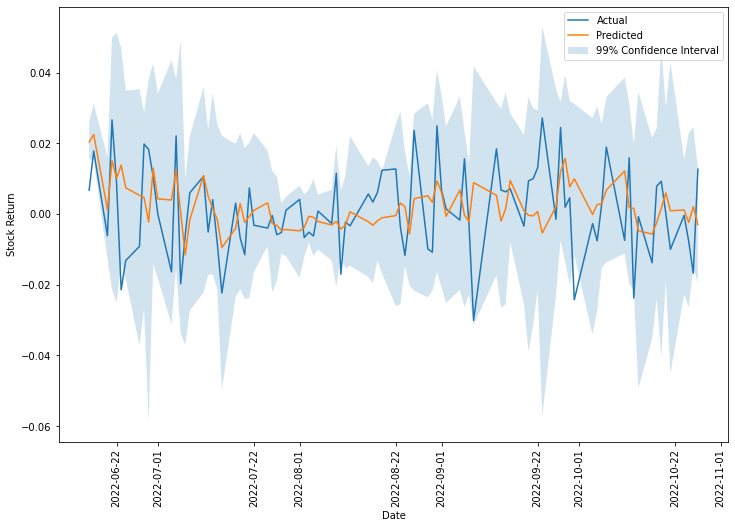

In [ ]:
# Compute mean and 90% confidence intervals of the predicted distribution
mean = np.mean(preds, axis=1)
p05 = np.percentile(preds, 0.5, axis=1)
p995 = np.percentile(preds, 99.5, axis=1)

# Plot the predicted distribution against the actual distribution
plt.figure(figsize = (12,8))
plt.plot(df_pr.index[-len(mean):], df_pr['Return'].iloc[-len(mean):])
plt.plot(df_pr.index[-len(mean):], mean)
plt.fill_between(df_pr.index[-len(mean):], p05, p995, alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Stock Return")
plt.xticks(rotation = '90')
plt.legend(["Actual", "Predicted", "99% Confidence Interval"])
plt.show()